# Interpretable Active Learning

In [1]:
# coding: utf-8
import pickle
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Reading and Processing Propublica Data

In [2]:
#https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv
df = pd.read_csv('recidivism-2-years.csv', index_col=0)

### Recommended cleaning steps

In [3]:
# See cell 2 here https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
df = df[(df["is_recid"] != -1) & (df["days_b_screening_arrest"] <= 30) & (df["days_b_screening_arrest"] >= -30) & (df["c_charge_degree"] != "O") & (df["score_text"] != "N/A")]

In [4]:
did_recidivate = df['two_year_recid'].as_matrix()
dec_score = df['decile_score'].as_matrix()
racial_desc = df["race"]

# Retaining only those attributes allowed to be used in recidivism predictions and sentencing
columns_to_keep = ["sex", "age", "age_cat", "juv_fel_count", "juv_misd_count",
                   "juv_other_count", "priors_count", "c_charge_degree"]
df = df[columns_to_keep]

In [5]:
# Get categorical features and dump redundant
df_bin = pd.get_dummies(df)
df_bin = df_bin.drop('sex_Female', axis=1)
df_bin = df_bin.drop('c_charge_degree_M', axis=1)

X = df_bin.as_matrix()

In [6]:
# Active learning criteria
def uncertainty_sample_proba(clf, x):
    probs = clf.predict_proba(x)
    return np.amax(probs, axis=1)

### Splitting the training and validation sets

In [7]:
# Pool data
count = 0
from random import shuffle
idx = range(len(X))
shuffle(idx)
init_pool = idx[0:400]
valida_pool = idx[-2000:]
idx = idx[0:-2000]
outside_pool = set(idx).difference(init_pool)

In [8]:
def di_calc(clf, X, protected_attribute_indices, uncertainty_cutoff=None):
    """Calculate disparate impact given all minority class indices"""
    probs = uncertainty_sample_proba(clf, X)
    if uncertainty_cutoff is None:
        uncertainty_cutoff = np.median(probs)
    protected_majority = set(range(X.shape[0])) - set(protected_attribute_indices)
    protected_majority = list(protected_majority)
    certain = probs >= uncertainty_cutoff
    
    # As defined here: https://arxiv.org/pdf/1412.3756.pdf - check page 5.
    a = float(np.count_nonzero(certain[protected_attribute_indices] == False))
    c = float(np.count_nonzero(certain[protected_attribute_indices]))
    b = float(np.count_nonzero(certain[protected_majority] == False))
    d = float(np.count_nonzero(certain[protected_majority]))
    
    if a == 0:
        a = 0.00001
    if b == 0:
        b = 0.00001
    if c == 0:
        c = 0.00001
    if d == 0:
        d = 0.00001
    
    pos_likelihood_ratio = (d / (b + d)) / (c / (c + a))

    return 1 - 1/pos_likelihood_ratio

In [9]:
# Note protected attributes
race_Hispanic_ids = [index for index, is_class in enumerate((racial_desc == 'Hispanic').as_matrix()) if is_class]
race_Asian_ids =  [index for index, is_class in enumerate((racial_desc == 'Asian').as_matrix()) if is_class]
race_African_American =  [index for index, is_class in enumerate((racial_desc == 'African-American').as_matrix()) if is_class]
race_Caucasian = [index for index, is_class in enumerate((racial_desc == 'Caucasian').as_matrix()) if is_class]

male_ids = [index for index, is_class in enumerate((df['sex'] == 'Male').as_matrix()) if is_class]
female_ids = [index for index, is_class in enumerate((df['sex'] == 'Female').as_matrix()) if is_class]

## Basic experimental run

In [10]:
# Training run
startTime = datetime.now()

performances = []
perf_ns = []

clf = LogisticRegression(solver='sag', max_iter=1000, random_state=42,
                             multi_class='multinomial')
clf.fit(X[init_pool, :], did_recidivate[init_pool])
predictions = clf.predict(X[valida_pool, :])
performances.append(accuracy_score(predictions, did_recidivate[valida_pool]))
perf_ns.append(len(init_pool))

di_black = []
di_hispanic = []
di_asian = []
di_white = []

di_male = []
di_female = []

mean_certainties_black = []
mean_certainties_hispanic = []
mean_certainties_asian = []
mean_certainties_white = []

for i in range(2000):
    probs = uncertainty_sample_proba(clf, X[sorted(outside_pool), :])
    index = sorted(outside_pool)[np.argmin(probs)]
    init_pool.append(index)
    outside_pool.remove(index)
        
    clf.fit(X[init_pool, :], did_recidivate[init_pool])
    predictions = clf.predict(X[valida_pool, :])
    performances.append(accuracy_score(predictions, did_recidivate[valida_pool]))
    perf_ns.append(len(init_pool))
    
    # Record disparate impact of uncertainty
    di_black.append(di_calc(clf, X, race_African_American))
    di_hispanic.append(di_calc(clf, X, race_Hispanic_ids))
    di_asian.append(di_calc(clf, X, race_Asian_ids))
    di_white.append(di_calc(clf, X, race_Caucasian))
    
    di_male.append(di_calc(clf, X, female_ids))
    di_male.append(di_calc(clf, X, male_ids))
    
    # Record mean certainties
    probs = uncertainty_sample_proba(clf, X)
    mean_certainties_black.append(np.mean(probs[race_African_American]))
    mean_certainties_hispanic.append(np.mean(probs[race_Hispanic_ids]))
    mean_certainties_asian.append(np.mean(probs[race_Asian_ids]))
    mean_certainties_white.append(np.mean(probs[race_Caucasian]))

    assert(len(performances)==len(perf_ns))

print datetime.now() - startTime

0:05:14.537366


In [11]:
run_num = 0
with open('all_performances_{}.pl'.format(run_num), 'wb') as f:
    pickle.dump([di_black,di_hispanic, di_asian, di_white, di_male, di_female, mean_certainties_black, mean_certainties_hispanic, mean_certainties_asian, mean_certainties_white, performances], f)

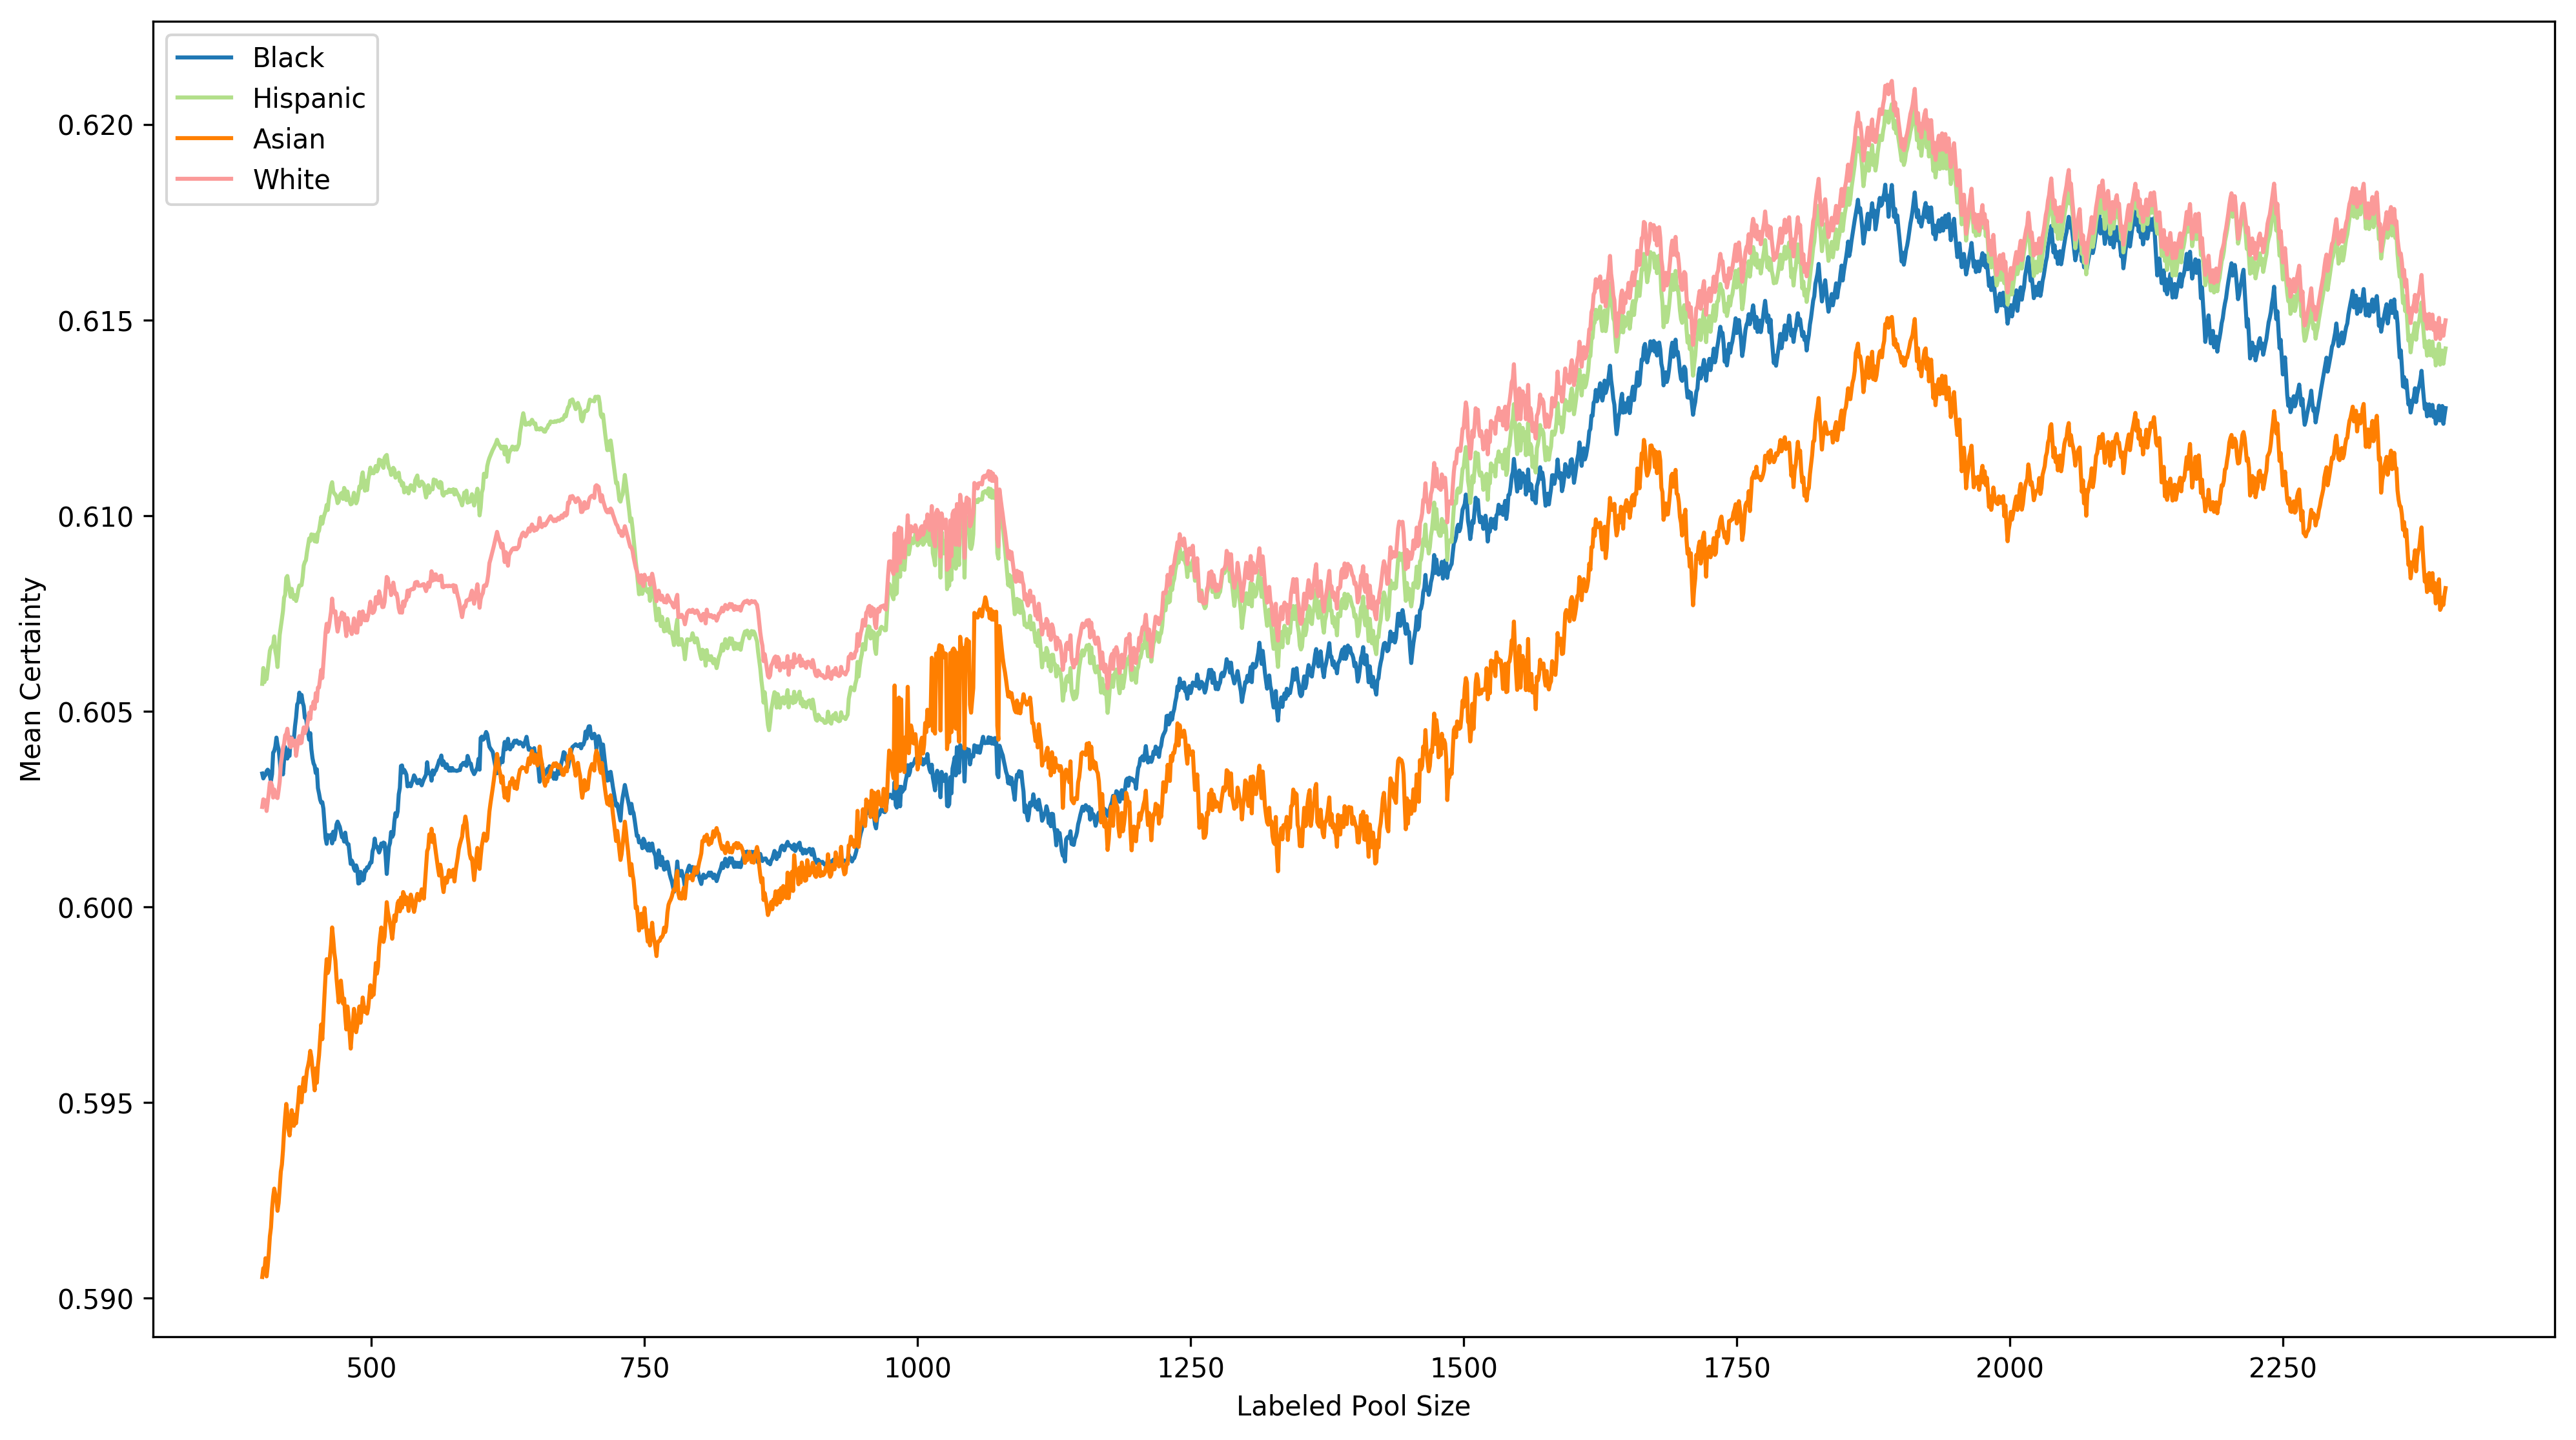

In [12]:
plt.figure(figsize=(16,9), dpi=300)
plt.plot(perf_ns[:-1], mean_certainties_black, color=plt.cm.Paired(0.1))
plt.plot(perf_ns[:-1], mean_certainties_hispanic, color=plt.cm.Paired(0.2))
plt.plot(perf_ns[:-1], mean_certainties_asian, color=plt.cm.Paired(0.6))
plt.plot(perf_ns[:-1], mean_certainties_white, color=plt.cm.Paired(0.4))
plt.xlabel('Labeled Pool Size')
plt.ylabel('Mean Certainty')
plt.legend(['Black', 'Hispanic', 'Asian', 'White'], loc='best')
plt.show()

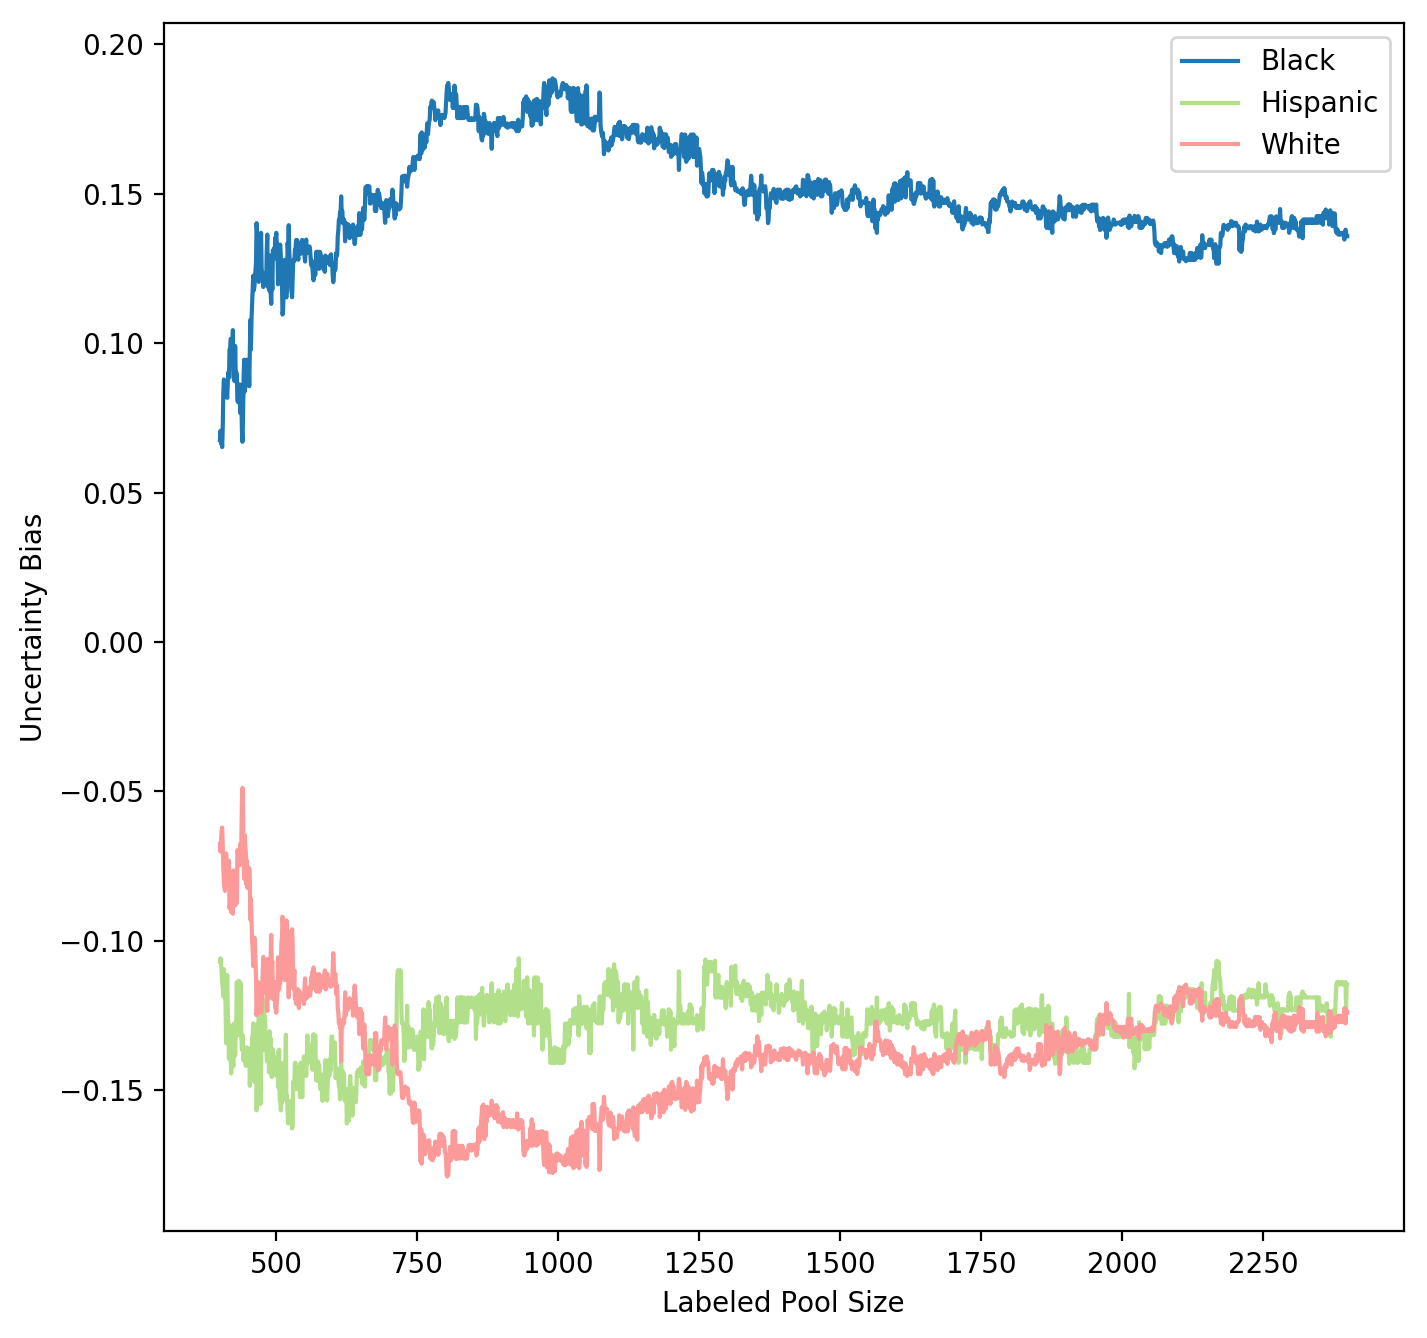

In [13]:
plt.figure(figsize=(2,2), dpi=400)
fig, ax1 = plt.subplots(figsize=(8,8), dpi=200)
plt.plot(perf_ns[:-1], di_black, color=plt.cm.Paired(0.1))
plt.plot(perf_ns[:-1], di_hispanic, color=plt.cm.Paired(0.2))
plt.plot(perf_ns[:-1], di_white, color=plt.cm.Paired(0.4))
plt.legend(['Black', 'Hispanic', 'White'], loc='best')
plt.xlabel('Labeled Pool Size')
plt.ylabel('Uncertainty Bias')
plt.show()

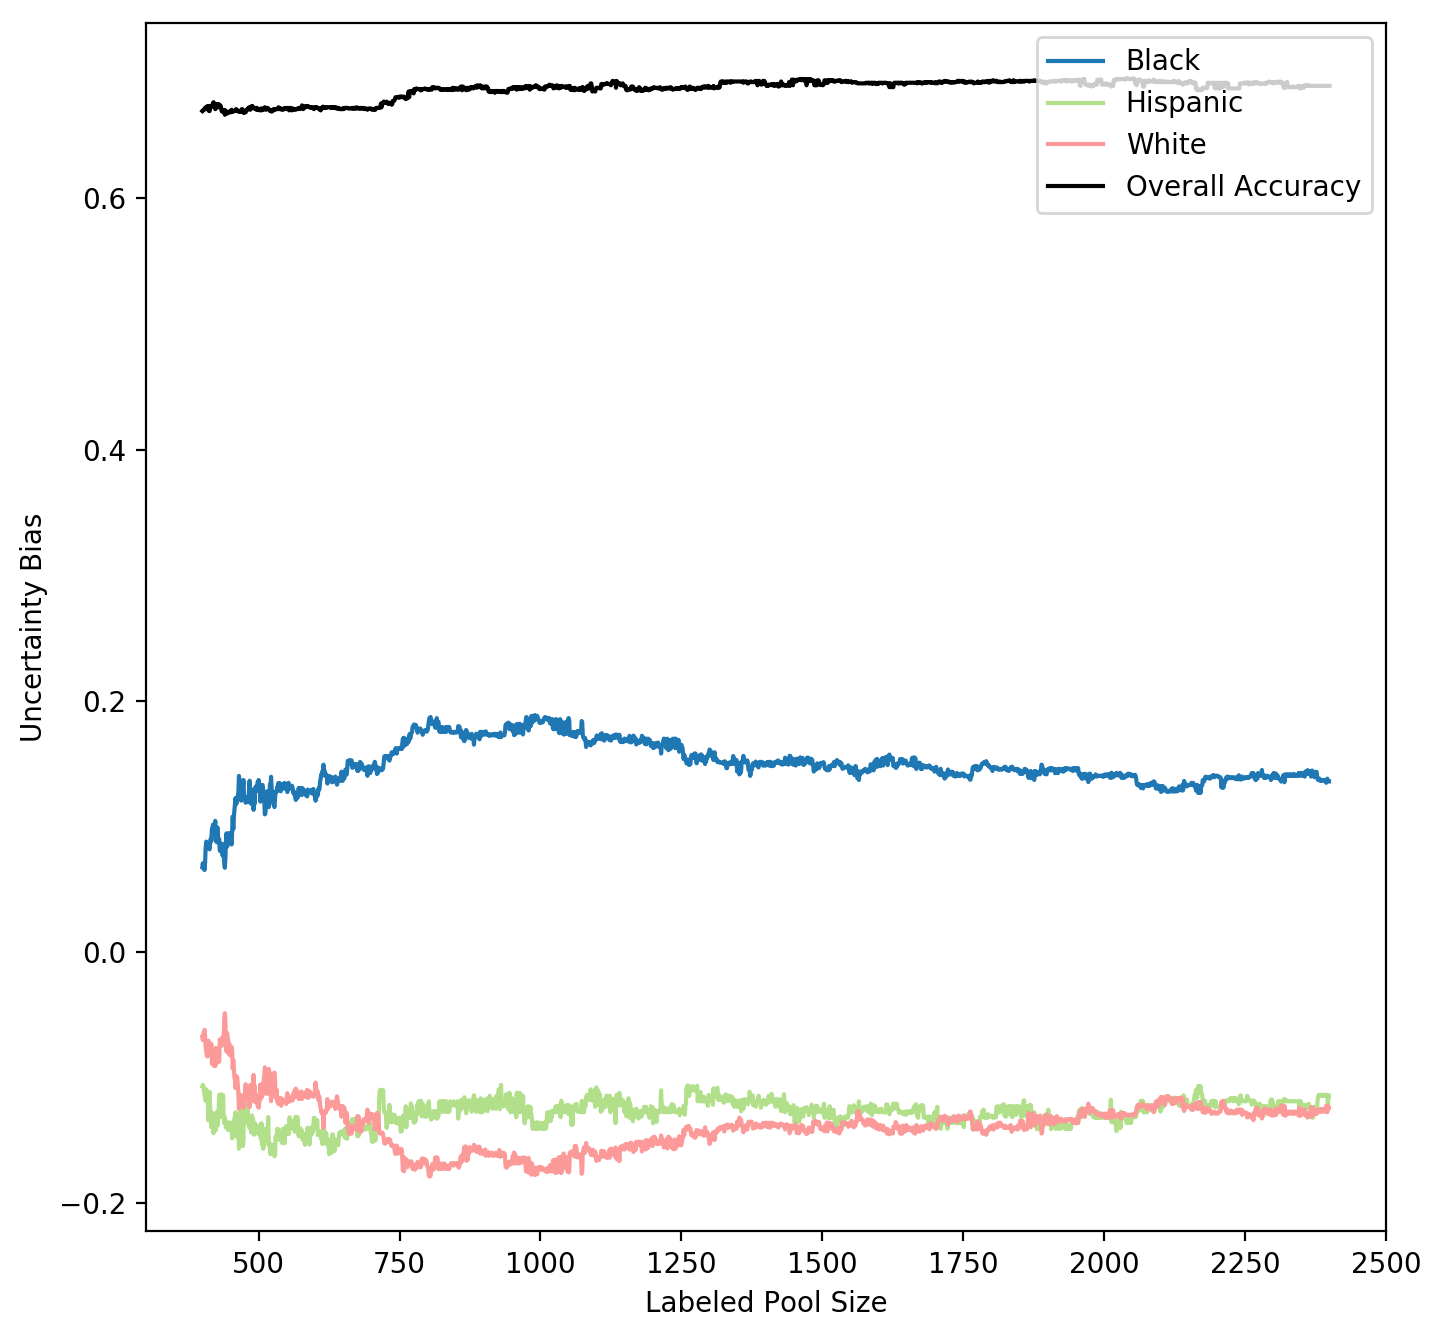

In [14]:
plt.figure(figsize=(2,2), dpi=400)
fig, ax1 = plt.subplots(figsize=(8,8), dpi=200)
plt.plot(perf_ns[:-1], di_black, color=plt.cm.Paired(0.1))
plt.plot(perf_ns[:-1], di_hispanic, color=plt.cm.Paired(0.2))
plt.plot(perf_ns[:-1], di_white, color=plt.cm.Paired(0.4))
plt.plot(perf_ns, performances, color=(0, 0, 0))
plt.legend(['Black', 'Hispanic', 'White', 'Overall Accuracy'], loc='upper right')
plt.xlabel('Labeled Pool Size')
plt.ylabel('Uncertainty Bias')
plt.show()

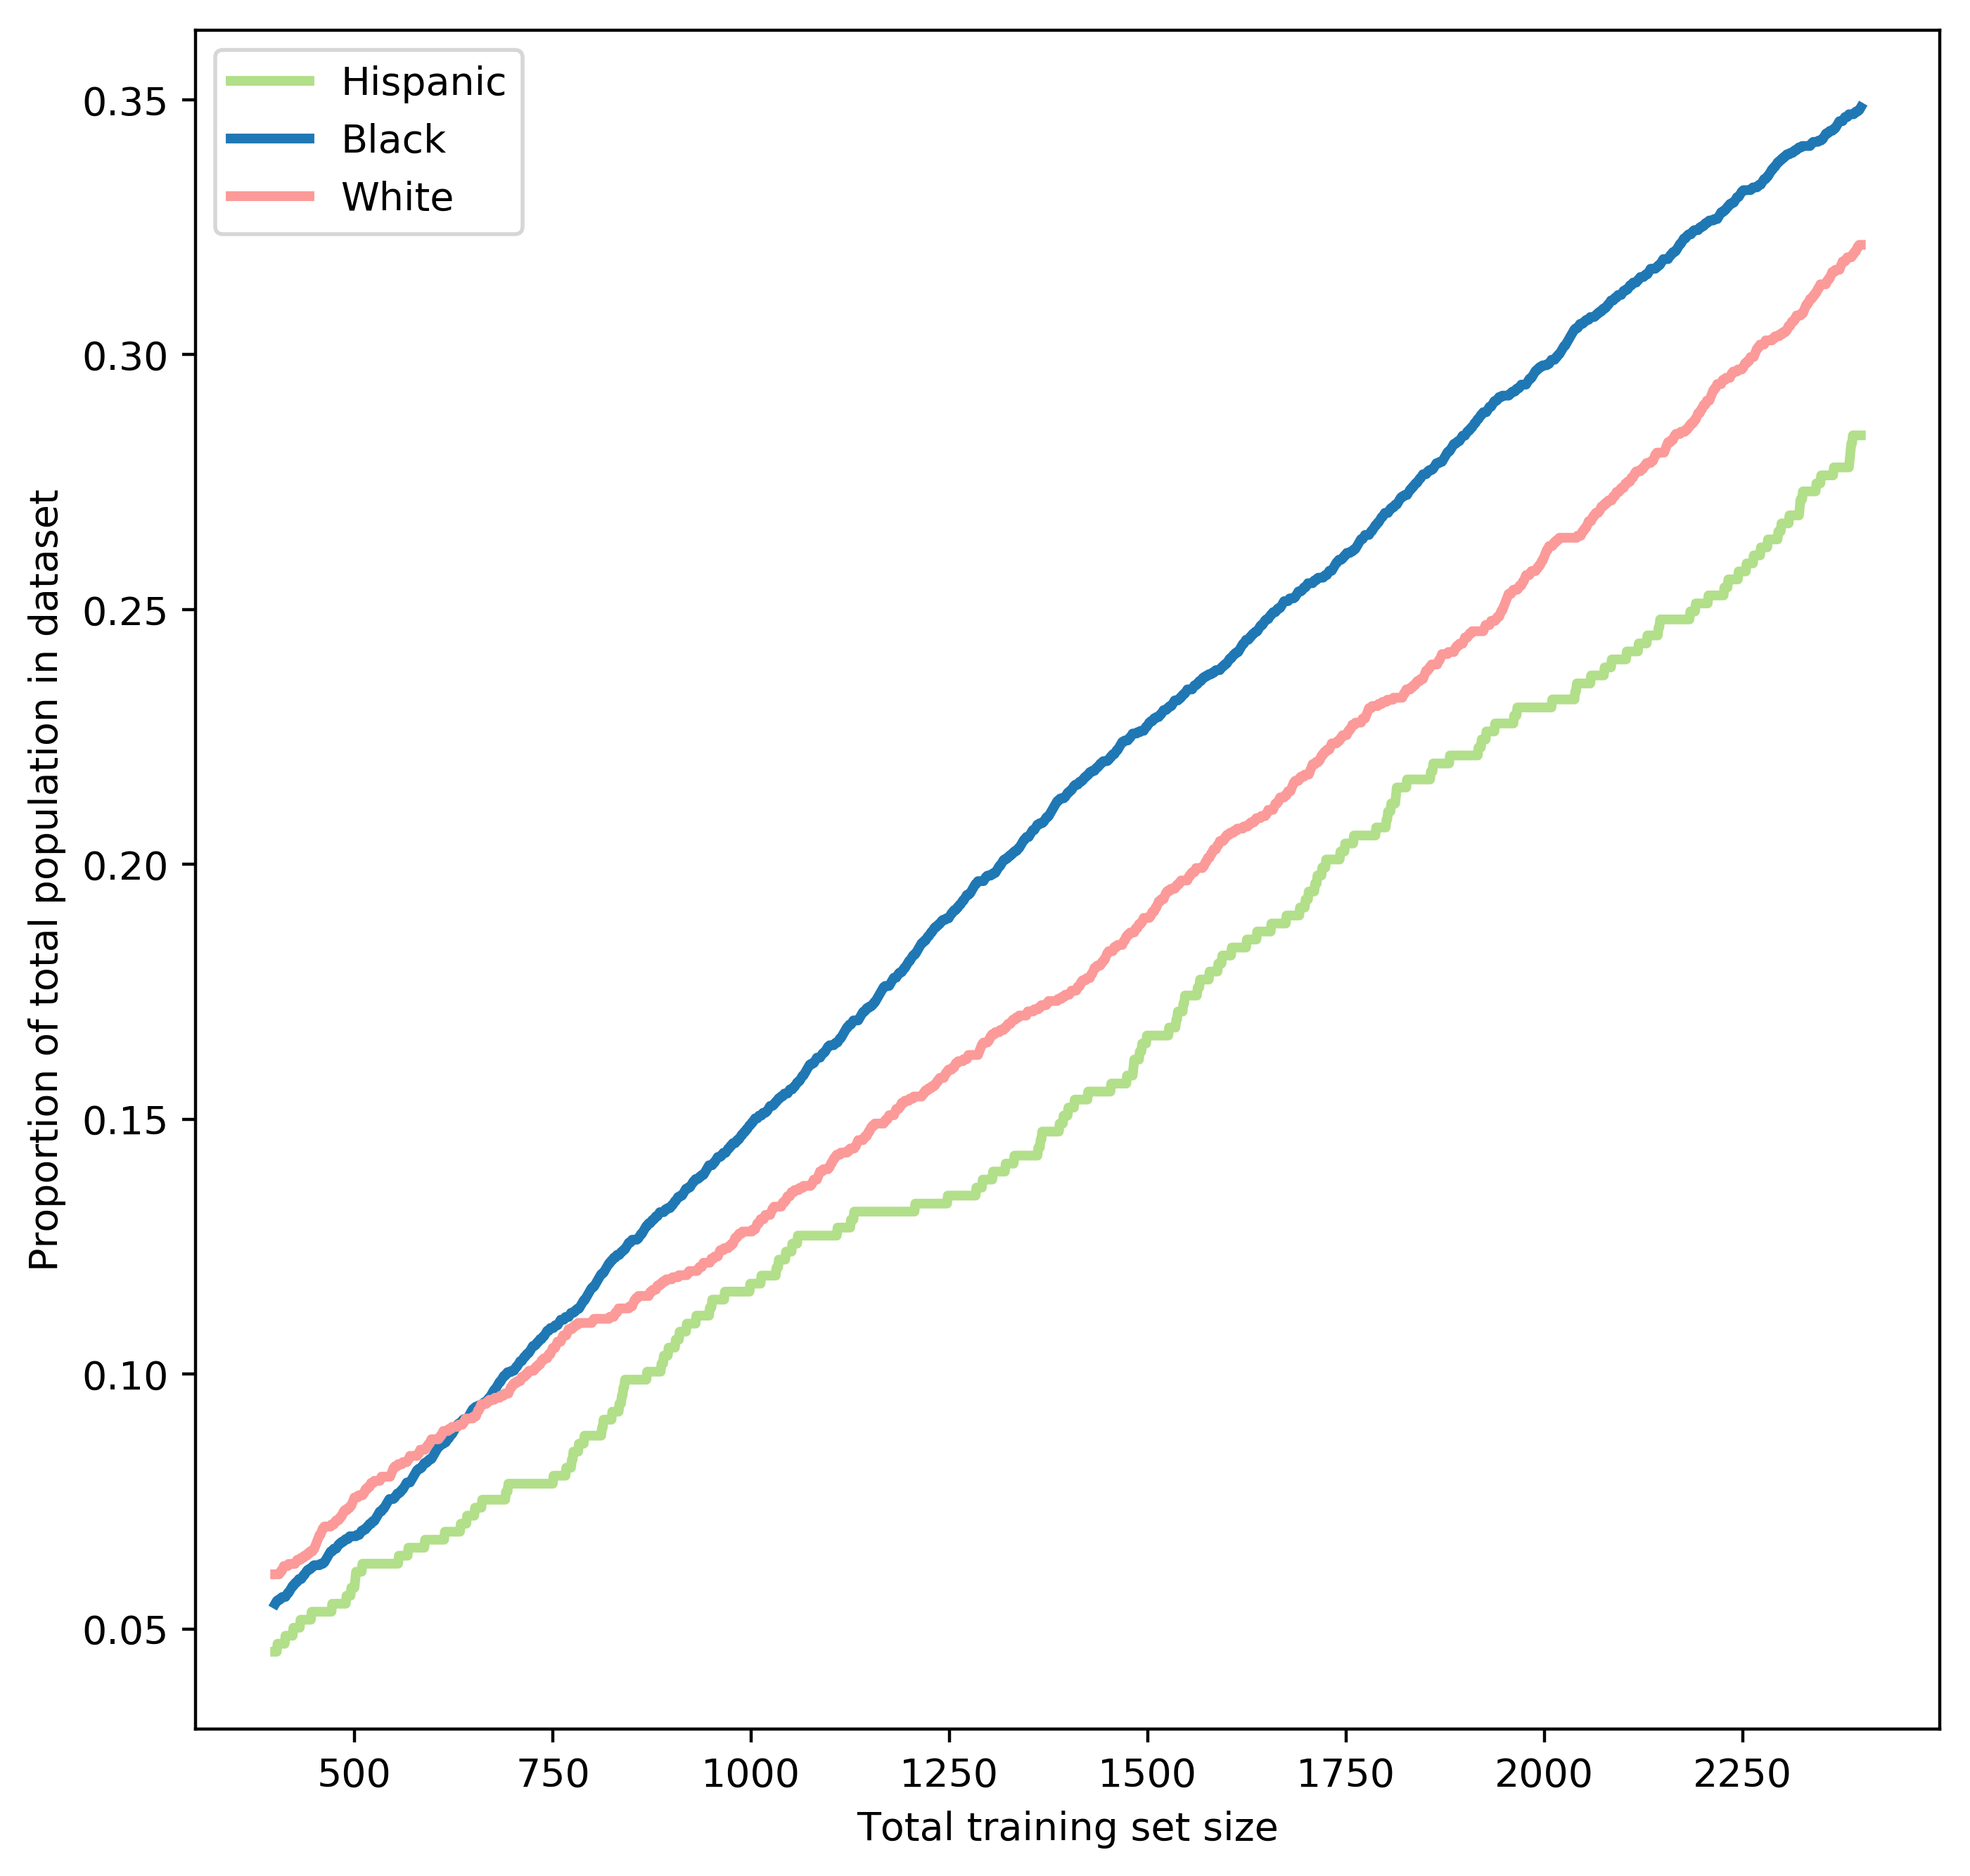

In [15]:
plt.figure(figsize=(8,8), dpi=400)

race_cumulative_sums = []
for i in init_pool:
    if i in race_Hispanic_ids:
        race_cumulative_sums.append(np.array([1,0,0,0]))
    elif i in race_African_American:
        race_cumulative_sums.append(np.array([0,0,1,0]))
    elif i in race_Caucasian:
        race_cumulative_sums.append(np.array([0,0,0,1]))
    else:
        race_cumulative_sums.append(np.array([0,0,0,0]))
    
race_cumulative_sums = np.cumsum(race_cumulative_sums, axis=0)

colors = [0.2, 0.1, 0.4]
for i, total_head_count, color in zip([0, 2, 3], [637, 3696, 2454], colors):
     plt.plot(perf_ns[:-1], race_cumulative_sums[400:, i]/float(total_head_count), color=plt.cm.Paired(color), linewidth=2.5)

plt.xlabel("Total training set size")
plt.ylabel("Proportion of total population in dataset")
plt.legend(['Hispanic', 'Black', 'White'], loc='best')
plt.show()